Tutorial 3: Complex Source
==========================

Up to now, we've not paid much attention to the source-`Galaxy`'s morphology. We've assumed its a single-component
exponential profile, which is a fairly crude assumption. A quick look at any image of a real galaxy reveals a
wealth of different structures that could be present - bulges, disks, bars, star-forming knots and so on. Furthermore,
there could be more than one source-galaxy!

In this example, we'll explore how far we can get trying to_fit a complex source using a pipeline. Fitting complex
source's is an exercise in diminishing returns. Each component we add to our source model brings with it an
extra 5-7, parameters. If there are 4 components, or multiple `Galaxy`'s we're quickly entering the somewhat nasty
regime of 30-40+ parameters in our non-linear search. Even with a pipeline, that is a lot of parameters to fit!

In [1]:
#%matplotlib inline
%matplotlib inline
from pyprojroot import here
workspace_path = str(here())
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

from os import path
import autolens as al
import autolens.plot as aplt

/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace
Working Directory has been set to `/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace`


we'll use new strong lensing data, where:

 - The lens galaxy's light is omitted.
 - The lens galaxy's total mass distribution is an `EllipticalIsothermal`.
 - The source galaxy's `LightProfile` is four `EllipticalSersic``..

In [2]:
dataset_name = "mass_sie__source_sersic_x4"
dataset_path = path.join("dataset", "imaging", "no_lens_light", dataset_name)

imaging = al.Imaging.from_fits(
    image_path=path.join(dataset_path, "image.fits"),
    noise_map_path=path.join(dataset_path, "noise_map.fits"),
    psf_path=path.join(dataset_path, "psf.fits"),
    pixel_scales=0.05,
)

We need to choose our mask for the analysis. Given the lens light is present in the image we'll need to include all 
of its light in the central regions of the image, so lets use a circular mask.

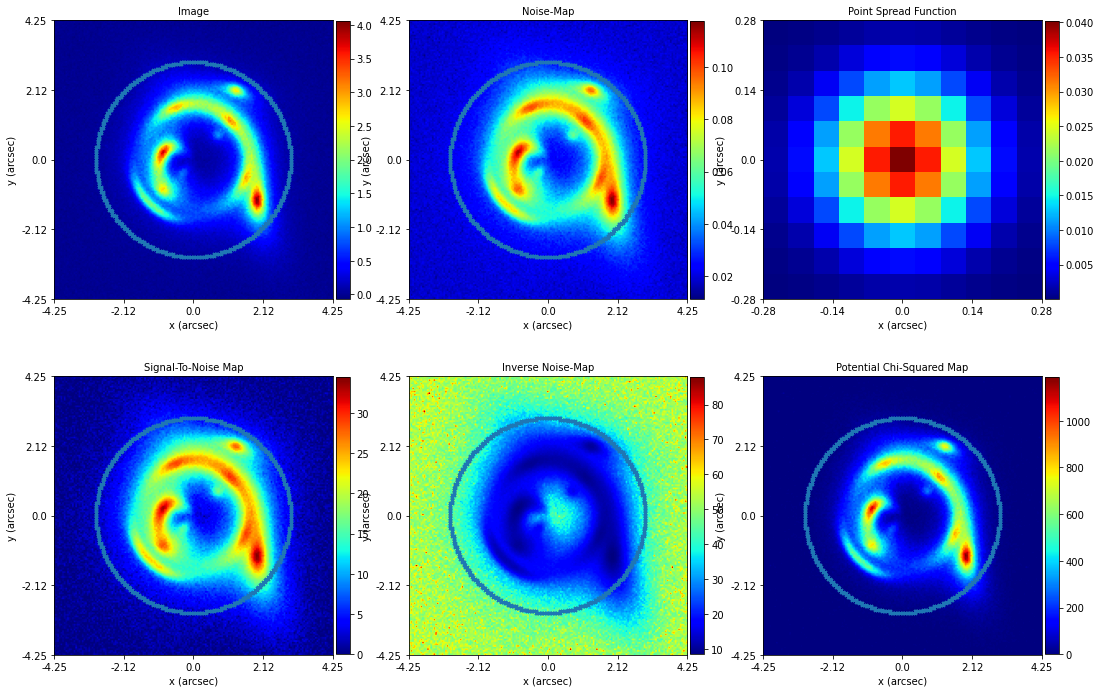

In [3]:
mask = al.Mask2D.circular(
    shape_native=imaging.shape_native, pixel_scales=imaging.pixel_scales, radius=3.0
)

imaging_plotter = aplt.ImagingPlotter(
    imaging=imaging, visuals_2d=aplt.Visuals2D(mask=mask)
)
imaging_plotter.subplot_imaging()

Yep, that`s a pretty complex source. There are clearly more than 4 peaks of light - I wouldn't like to guess how many
sources of light there truly is! You'll also notice I omitted the lens galaxy's light for this system. This is to 
keep the number of parameters down and the phases running fast, but we wouldn't get such a luxury for a real galaxy.

__Settings__

The `SettingsPhaseImaging` describe how the model is fitted to the data in the log likelihood function. We discussed
these in chapter 2, and a full description of all settings can be found in the example script:

 `autolens_workspace/notebooks/modeling/customize/settings.py`.

The settings chosen here are applied to all phases in the pipeline.

In [4]:
settings_masked_imaging = al.SettingsMaskedImaging(grid_class=al.Grid2D, sub_size=2)

settings = al.SettingsPhaseImaging(settings_masked_imaging=settings_masked_imaging)

__Pipeline Creation__

To create a `Pipeline`, we call a `make_pipeline` function, which is written in its own Python script: 

 `tutorial_3_complex_source.py`. 

Before we check it out, lets get the pipeline running, by importing the script, running the `make_pipeline` function
to create the `Pipeline` object and calling that objects `run` function.

The `path_prefix` below specifies the path the pipeline results are written to, which is:

 `autolens_workspace/output/howtolens/c3_t3_complex_source/pipeline_name/setup_tag/name/settings_tag`

In [5]:
from pipelines import tutorial_3_pipeline_complex_source

pipeline_complex_source = tutorial_3_pipeline_complex_source.make_pipeline(
    path_prefix=path.join("howtolens", "c3_t3_complex_source"),
    settings=settings,
    redshift_lens=0.5,
    redshift_source=1.0,
)

# Uncomment to run.
# pipeline_complex_source.run(dataset=imaging, mask=mask)

Okay, so with 4 sources, we still couldn`t get a good a fit to the source that didn`t leave residuals. However, I 
actually simulated the lens with 4 sources. This means that there is a `perfect fit` somewhere in parameter space 
that we unfortunately missed using the pipeline above.

Lets confirm this, by manually fitting the `Imaging` data with the true input model.

/home/jammy/venvs/PyAuto/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


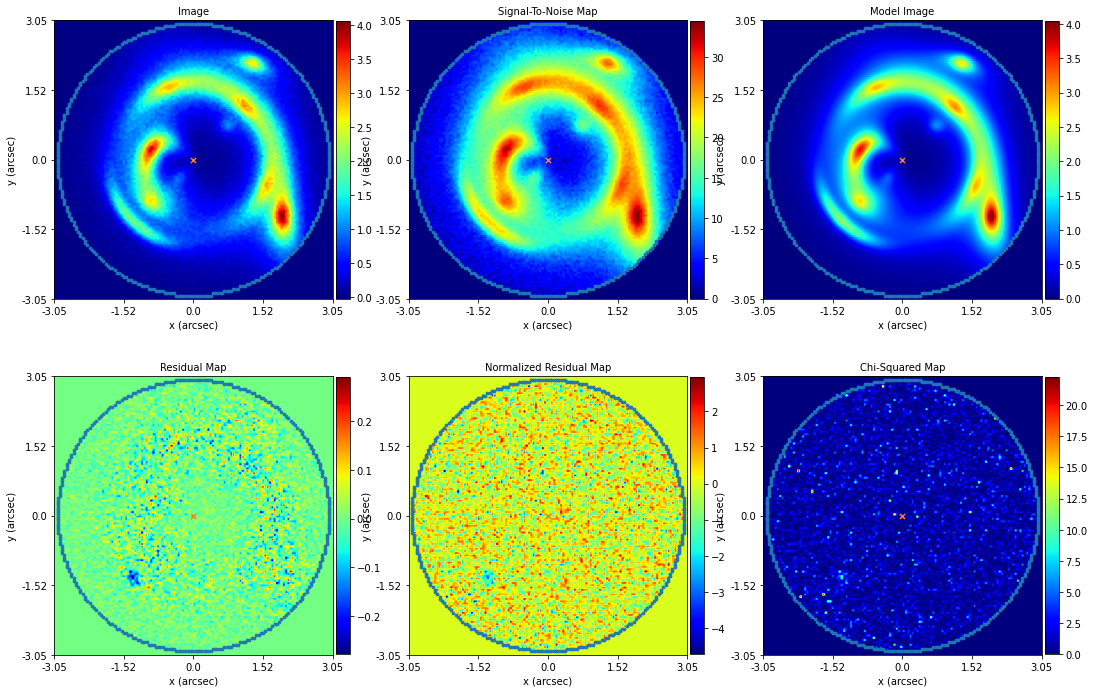

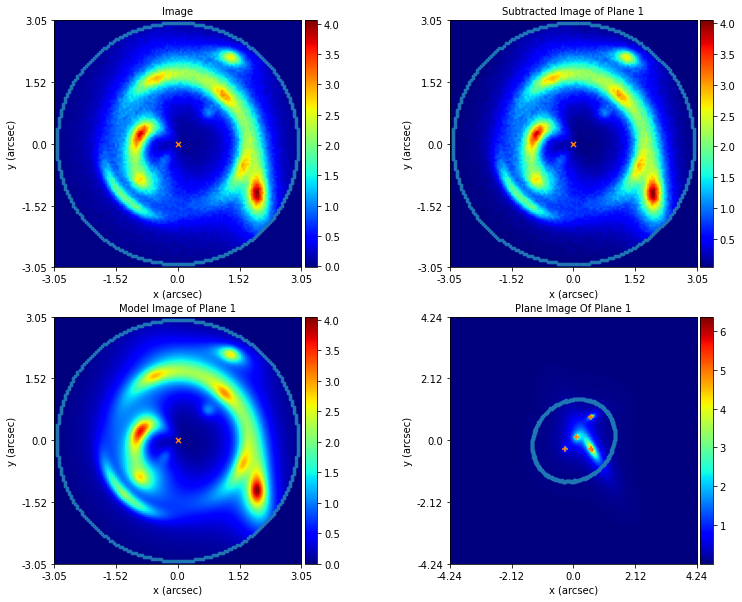

In [6]:
masked_imaging = al.MaskedImaging(
    imaging=imaging,
    mask=al.Mask2D.circular(
        shape_native=imaging.shape_native, pixel_scales=imaging.pixel_scales, radius=3.0
    ),
)

lens_galaxy = al.Galaxy(
    redshift=0.5,
    mass=al.mp.EllipticalIsothermal(
        centre=(0.0, 0.0), einstein_radius=1.6, elliptical_comps=(0.17647, 0.0)
    ),
)

source_galaxy = al.Galaxy(
    redshift=1.0,
    light_0=al.lp.EllipticalSersic(
        centre=(0.1, 0.1),
        elliptical_comps=al.convert.elliptical_comps_from(axis_ratio=0.8, phi=60.0),
        intensity=0.1,
        effective_radius=1.0,
        sersic_index=2.5,
    ),
    light_1=al.lp.EllipticalSersic(
        centre=(0.8, 0.6),
        elliptical_comps=al.convert.elliptical_comps_from(axis_ratio=0.5, phi=30.0),
        intensity=0.2,
        effective_radius=0.3,
        sersic_index=3.0,
    ),
    light_2=al.lp.EllipticalSersic(
        centre=(-0.3, 0.6),
        elliptical_comps=al.convert.elliptical_comps_from(axis_ratio=0.3, phi=120.0),
        intensity=0.6,
        effective_radius=0.5,
        sersic_index=1.5,
    ),
    light_3=al.lp.EllipticalSersic(
        centre=(-0.3, -0.3),
        elliptical_comps=al.convert.elliptical_comps_from(axis_ratio=0.9, phi=85.0),
        intensity=0.4,
        effective_radius=0.1,
        sersic_index=2.0,
    ),
)

tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, source_galaxy])

true_fit = al.FitImaging(masked_imaging=masked_imaging, tracer=tracer)

fit_imaging_plotter = aplt.FitImagingPlotter(fit=true_fit)
fit_imaging_plotter.subplot_fit_imaging()
fit_imaging_plotter.subplot_of_planes(plane_index=1)

And indeed, we see an improved residual-map, chi-squared-map, and so forth.

The morale of this story is that if the source morphology is complex, there is no way we can build a pipeline to 
fit it. For this tutorial, this was true even though our source model could actually fit the data perfectly. For real 
lenses, the source will be *even more complex* and there is even less hope of getting a good fit :(

But fear not, **PyAutoLens** has you covered. In chapter 4, we'll introduce a completely new way to model the source 
galaxy, which addresses the problem faced here. But before that, in the next tutorial we'll discuss how we actually 
pass priors in a pipeline.